# 欠損データへの対処
まずは数値データ。  
csv (comma-separated values)を作る


In [1]:
import pandas as pd
from io import StringIO

# サンプルデータを作成
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [2]:
# 各特徴量の欠損値をカウント
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [3]:
# 欠損値を含む行を削除
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [4]:
# 欠損値を含む列を削除
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [5]:
# 全ての列が NaN である行だけ削除
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# 非 NaN 個が4つ未満の行を削除
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# 特定の列にNaNが含まれている行だけを削除
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [8]:
#from sklearn.preprocessing import Imputer
# Version 0.20.4 から以下のように変更
from sklearn.impute import SimpleImputer
# df.values の型は numpy.ndarray なので、NaN=np.nan
import numpy as np
# 欠損値補完のインスタンスを作成(平均値補完)
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
# データを適合
imr.fit(df)
# 補完を実行
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [9]:
# 補完前と比較
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

# カテゴリデータの処理
今度はカテゴリ。
* 名義(nominal): 「色」赤、青
* 順序(ordinal): 「サイズ」S < M < L

In [10]:
import pandas as pd
# サンプルデータを生成(Tシャツの色・サイズ・価格・クラスラベル)
df = pd.DataFrame([
['green', 'M', 10.1, 'class1'],
['red', 'L', 13.5, 'class2'],
['blue', 'XL', 15.3, 'class1']])

# 列名を指定
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [11]:
# Tシャツのサイズと整数を対応
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
# Tシャツのサイズを整数に変換
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [12]:
import numpy as np
# クラスラベルと整数を対応させる
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [13]:
# クラスラベルを整数に変換
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [14]:
# 整数とクラスラベルを対応させる
inv_class_mapping = {v: k for k, v in class_mapping.items()}
# 整数からクラスラベルへ変換
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [15]:
# scikit-learn の　LabelEncoder を導入
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
# クラスラベルから整数への対応(fit) + 変換(transform)
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [16]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X
# blue -> 0
# green -> 1
# red -> 2
# blue < green < red ???

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [17]:
# color に　one-hot エンコーディングの適用
C = X.T[0].T
C = C.reshape(-1, 1)
C

array([[1],
       [2],
       [0]], dtype=object)

In [18]:
# one-hot エンコーディング
from sklearn.preprocessing import OneHotEncoder
# one-hot エンコーダの作成
ohe = OneHotEncoder(handle_unknown='ignore')
# one-hot エンコーディングを実行
ohe.fit_transform(C).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [19]:
from sklearn.compose import ColumnTransformer
ohe = OneHotEncoder()
ct = ColumnTransformer([('categorical', ohe, [0])], remainder='passthrough')

X = ct.fit_transform(X)
X

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

# データセットをトレーニング/テストに分割

In [20]:
# wine データセットを読み込む
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# 列名を設定
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
# 先頭５行を表示
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [0]:
from sklearn.model_selection import train_test_split
# 特徴量とクラスラベルを別々に抽出
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0]
# トレーニングデータとテストデータに分割
# 全体の30％をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 特徴量のスケーリング

In [0]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
# min-max スケーリングのインスタンスを生成
mms = MinMaxScaler()
# トレーニングデータでスケーリングを学習(fit)、実行(transform)
X_train_norm = mms.fit_transform(X_train)
# テストデータをスケーリング
X_test_norm = mms.fit(X_test)

In [0]:
# 標準化
from sklearn.preprocessing import StandardScaler
# 標準化のインスタンスを生成
stdsc = StandardScaler()
# トレーニングデータで標準化を学習(fit)、実行(transform)
X_train_std = stdsc.fit_transform(X_train)
# テストデータをスケーリング
X_test_std = stdsc.fit_transform(X_test)

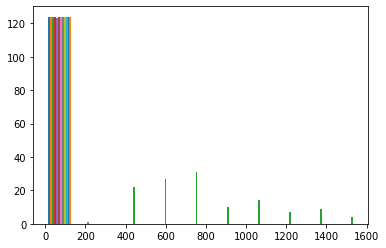

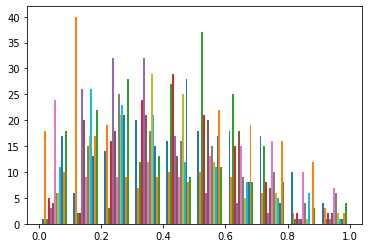

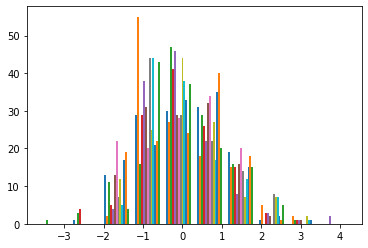

In [24]:
import matplotlib.pyplot as plt
plt.hist(X_train)
plt.show()

plt.hist(X_train_norm)
plt.show()

plt.hist(X_train_std)
plt.show()

# 有益な特徴量の選択

In [25]:
# L1正則化
from sklearn.linear_model import LogisticRegression
# L1正則化ロジスティック回帰のインスタンスを生成
# L1正則化は liblinear, saga の solver のみ対応している(default=lbfgs)
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
# トレーニングデータに適合
lr.fit(X_train_std, y_train)
# トレーニングデータに対する正解率の表示
print('Training accuracy: ', lr.score(X_train_std, y_train))
# テストデータに対する正解率の表示
print('Test accuracy: ', lr.score(X_test_std, y_test))

Training accuracy:  0.9838709677419355
Test accuracy:  0.9814814814814815


In [26]:
# 切片の表示
lr.intercept_

array([-0.38385391, -0.15808076, -0.70046847])

In [27]:
# 重み係数の表示
lr.coef_

array([[ 0.2804354 ,  0.        ,  0.        , -0.02792413,  0.        ,
         0.        ,  0.71012692,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23604692],
       [-0.64398717, -0.06882159, -0.05720716,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92685402,
         0.06014191,  0.        , -0.37102683],
       [ 0.        ,  0.06149971,  0.        ,  0.        ,  0.        ,
         0.        , -0.63559141,  0.        ,  0.        ,  0.49775223,
        -0.3583675 , -0.57168365,  0.        ]])

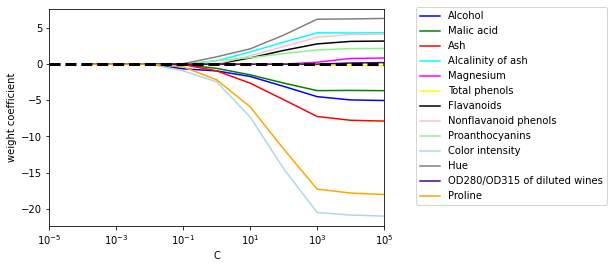

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

# 各係数の色のリスト
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']
# 重み係数、逆正則化パラメータC
weights, params = [], []
# 逆正則化パラメータごとに生成
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0, solver='liblinear')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

plt.show()

# Sequential Backward Selection: SBS
* 評価関数を最大化する特徴量を決定
* 特徴量の就業から削除
* 特徴量が目的の個数と等しくなるまで繰り返す

In [0]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
  """逐次後退選択を実行するクラス
  """

  def __init__(self, estimator, k_features, scoring=accuracy_score,
               test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = estimator
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state
  
  def fit(self, X, y):
    # データを分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
    # 特徴量の個数、列インデックス
    dim = X_train.shape[1]
    self.indices_ = tuple(range(dim))
    self.subsets_ = [self.indices_]
    # 特徴量を全て用いてスコアを算出
    score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)

    self.scores_ = [score]
    while dim > self.k_features:
      # 空のリストを作成
      scores = []
      subsets = []

      for p in combinations(self.indices_, r=dim-1):
        # スコアを算出して格納
        score = self._calc_score(X_train, y_train, X_test, y_test, p)
        scores.append(score)
        subsets.append(p)
      
      # 最良のスコアのインデックスを抽出
      best = np.argmax(scores)
      # 最良のスコアとなる列インデックスを抽出して格納
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      # 特徴量の個数を1つ減らして次のステップへ
      dim -= 1

      # スコアを格納
      self.scores_.append(scores[best])

    # 最後に格納したスコア
    self.k_score_ = self.scores_[-1]

    return self
  
  def transform(self, X):
    # 抽出した特徴量を返す
    return X[:, self.indices_]

  def _calc_score(self, X_train, y_train, X_test, y_test, indices):
    # 指定された列番号 indices の特徴量を抽出してモデルに適合
    self.estimator.fit(X_train[:, indices], y_train)
    # テストデータを用いてクラスラベルを予測
    y_pred = self.estimator.predict(X_test[:, indices])
    # 正解のクラスラベルと予測値からスコアを算出
    score = self.scoring(y_test, y_pred)
    return score

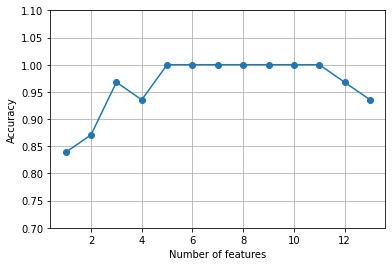

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
# k近傍分類器のインスタンスを生成(k=2)
knn = KNeighborsClassifier(n_neighbors=2)
# 逐次後退選択のインスタンスを生成
sbs = SBS(knn, k_features=1)
# 逐次後退選択を実行
sbs.fit(X_train_std, y_train)

# 近傍点の個数のリスト
k_feat = [len(k) for k in sbs.subsets_]
# 横軸：近傍点の個数、縦軸：スコア
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [31]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [32]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [33]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.9596774193548387
Test accuracy: 0.9259259259259259


# ランダムフォレストで特徴量の重要度を測定

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


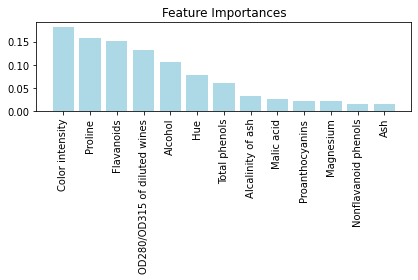

In [34]:
from sklearn.ensemble import RandomForestClassifier
# Wine データセットの特徴量の名称
feat_labels = df_wine.columns[1:]
# ランダムフォレストオブジェクトの生成
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
# モデルに適合
forest.fit(X_train, y_train)
# 特徴量の重要度を抽出
importances = forest.feature_importances_
# 重要度の好順で特徴量のインデックスを抽出
indices = np.argsort(importances)[::-1]
# 重要度の好順で特徴量の名称、重要度を表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [35]:
from sklearn.feature_selection import SelectFromModel

# 重要度が0.15以上の特徴量を抽出
sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
X_selected = sfm.transform(X_train)
X_selected.shape

(124, 3)